<a href="https://colab.research.google.com/github/NahidurRahaman/Machine_Learning/blob/main/thesisupdate(CK%2B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [48]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Load FER2013 CSV
csv_path = '/content/drive/MyDrive/FER2013/ckextended.csv'  # update path if needed
df = pd.read_csv(csv_path)

In [50]:
# Define emotion classes
emotion_labels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

import csv # Import the csv module

# Custom dataset from CSV
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pixels = list(map(int, self.df.iloc[idx]["pixels"].split()))
        img = np.asarray(pixels).reshape(48, 48).astype(np.uint8)
        img = Image.fromarray(img).convert("L")
        img = img.convert("RGB")  # convert to 3-channel RGB

        if self.transform:
            img = self.transform(img)

        label = int(self.df.iloc[idx]["emotion"])
        return img, label

In [51]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # random zoom crop
    transforms.RandomHorizontalFlip(),                    # flip
    transforms.RandomRotation(15),                        # rotate
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)                # normalize
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [52]:
# Split manually
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)

train_dataset = FER2013Dataset(train_df, transform=transform)
val_dataset = FER2013Dataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

Here is the code for the SRCNN model provided by the user. Note that this model is designed for super-resolution and takes a single-channel image as input and outputs a single-channel image.

In [53]:
import torch.nn as nn
import timm


In [54]:
class EfficientNetV2S_FeatureExtractor(nn.Module):
    def __init__(self):
        super(EfficientNetV2S_FeatureExtractor, self).__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in21k', pretrained=True, features_only=True)

    def forward(self, x):
        features = self.backbone(x)
        return features[-1]  # (B, 1280, 7, 7)

In [55]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
efficientnet_model = EfficientNetV2S_FeatureExtractor().to(device)
efficientnet_model.eval()

# Use first batch from train_loader
for images, labels in train_loader:
    images = images.to(device)  # shape: (B, 3, 224, 224)
    labels = labels.to(device)

    with torch.no_grad():
        features = efficientnet_model(images)  # shape: (B, 1280, 7, 7)

    print("Input shape:", images.shape)
    print("EfficientNetV2-S Output shape:", features.shape)
    break

Input shape: torch.Size([16, 3, 224, 224])
EfficientNetV2-S Output shape: torch.Size([16, 256, 7, 7])


In [57]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(ConvNeXtBlock, self).__init__()
        self.convnext = timm.create_model('convnext_tiny', pretrained=True, features_only=True)
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.proj(x)  # Reduce 256 → 256 (no change)
        return x  # shape: B × 256 × 7 × 7

In [58]:
class SE_MBConvBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(SE_MBConvBlock, self).__init__()
        self.expand = nn.Conv2d(in_channels, in_channels * 6, kernel_size=1)
        self.depthwise = nn.Conv2d(in_channels * 6, in_channels * 6, kernel_size=3, padding=1, groups=in_channels * 6)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 6, in_channels // 4, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 4, in_channels * 6, 1),
            nn.Sigmoid()
        )
        self.project = nn.Conv2d(in_channels * 6, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.expand(x)
        x = self.depthwise(x)
        se_weight = self.se(x)
        x = x * se_weight
        x = self.project(x)
        return x  # shape: B × 256 × 7 × 7

In [59]:
adaptive_pool = nn.AdaptiveAvgPool2d((28, 28))


In [60]:
class MultiBranchFeatureExtractor(nn.Module):
    def __init__(self):
        super(MultiBranchFeatureExtractor, self).__init__()
        self.efficientnet = EfficientNetV2S_FeatureExtractor()
        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()
        self.pool = nn.AdaptiveAvgPool2d((28, 28))  # Resize to 28×28

    def forward(self, x):
        x = self.efficientnet(x)  # Output: B × 1280 × 7 × 7

        convnext_feat = self.convnext_block(x)     # B × 256 × 7 × 7
        senet_feat    = self.se_mbconv_block(x)    # B × 256 × 7 × 7

        convnext_feat = self.pool(convnext_feat)   # B × 256 × 28 × 28
        senet_feat    = self.pool(senet_feat)      # B × 256 × 28 × 28

        return convnext_feat, senet_feat


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiBranchFeatureExtractor().to(device)
model.eval()

for images, labels in train_loader:
    images = images.to(device)

    with torch.no_grad():
        conv_feat, se_feat = model(images)

    print("ConvNeXt Output:", conv_feat.shape)  # [B, 256, 28, 28]
    print("SENet+MBConv Output:", se_feat.shape)  # [B, 256, 28, 28]
    break


ConvNeXt Output: torch.Size([16, 256, 28, 28])
SENet+MBConv Output: torch.Size([16, 256, 28, 28])


In [62]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=256, num_heads=4):
        super(CrossAttentionFusion, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, feat_q, feat_kv):
        # Input: B × 256 × 28 × 28
        B, C, H, W = feat_q.shape

        # Flatten to sequences: B × 784 × 256
        q = feat_q.view(B, C, -1).permute(0, 2, 1)   # Q: (B, 784, 256)
        kv = feat_kv.view(B, C, -1).permute(0, 2, 1) # K,V: (B, 784, 256)

        # Cross-attention
        attn_output, _ = self.attn(q, kv, kv)        # (B, 784, 256)
        attn_output = self.norm(attn_output + q)     # Residual + Norm

        # Reshape back to spatial map: (B, 256, 28, 28)
        fused = attn_output.permute(0, 2, 1).view(B, C, H, W)

        return fused  # Output: B × 256 × 28 × 28

In [63]:
class FullFeatureFusionBlock(nn.Module):
    def __init__(self):
        super(FullFeatureFusionBlock, self).__init__()
        self.backbone = MultiBranchFeatureExtractor()        # Gives conv_feat, se_feat
        self.cross_attn = CrossAttentionFusion(embed_dim=256, num_heads=4)

    def forward(self, x):
        conv_feat, se_feat = self.backbone(x)               # B × 256 × 28 × 28

        fused_feat = self.cross_attn(conv_feat, se_feat)    # B × 256 × 28 × 28

        return fused_feat  # ready for concatenation with other branches if needed

In [64]:
model = FullFeatureFusionBlock().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fused_output = model(images)

    print("Fused Output Shape:", fused_output.shape)  # Expected: [B, 256, 28, 28]
    break

Fused Output Shape: torch.Size([16, 256, 28, 28])


In [65]:
class GlobalContextBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(GlobalContextBranch, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.ReLU(),
            nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        x = self.global_pool(x)   # [B, 256, 1, 1] after global pool, originally [B, 256, 7, 7]
        x = self.fc(x)            # [B, 64, 28, 28]
        return x

In [66]:
class LocalDetailBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(LocalDetailBranch, self).__init__()
        self.local_cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.local_cnn(x)  # [B, 64, 28, 28]

In [67]:
class MultiBranchFullFusion(nn.Module):
    def __init__(self):
        super(MultiBranchFullFusion, self).__init__()
        self.feature_extractor = EfficientNetV2S_FeatureExtractor()

        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()

        self.pool = nn.AdaptiveAvgPool2d((28, 28))
        self.cross_attn = CrossAttentionFusion(embed_dim=256)

        self.global_context = GlobalContextBranch()
        self.local_detail = LocalDetailBranch()

        # Add pooling to ensure consistent spatial dimensions before concatenation
        self.global_pool_out = nn.AdaptiveAvgPool2d((28, 28))
        self.local_pool_out = nn.AdaptiveAvgPool2d((28, 28))


    def forward(self, x):
        feat = self.feature_extractor(x)                # [B, 256, 7, 7]

        # ConvNeXt & SENet+MBConv
        conv_feat = self.pool(self.convnext_block(feat))  # [B, 256, 28, 28]
        se_feat   = self.pool(self.se_mbconv_block(feat)) # [B, 256, 28, 28]

        # Cross-attention fused output
        fused_attn = self.cross_attn(conv_feat, se_feat)  # [B, 256, 28, 28]

        # Extra branches
        global_feat = self.global_context(feat)           # Expected: [B, 64, 28, 28]
        local_feat  = self.local_detail(feat)             # Expected: [B, 64, 28, 28]

        # Ensure spatial dimensions are 28x28 before concatenation
        global_feat_pooled = self.global_pool_out(global_feat)
        local_feat_pooled = self.local_pool_out(local_feat)


        # Concatenate all
        final_feat = torch.cat([conv_feat, se_feat, fused_attn, global_feat_pooled, local_feat_pooled], dim=1)  # [B, 896, 28, 28]
        return final_feat

In [68]:
model = MultiBranchFullFusion().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fusion_output = model(images)
    print("Final Fused Feature Shape:", fusion_output.shape)  # [B, 896, 28, 28]
    break


Final Fused Feature Shape: torch.Size([16, 896, 28, 28])


In [69]:
class MobileViTBlock(nn.Module):
    def __init__(self, in_channels, transformer_dim=128, patch_size=2, depth=2, heads=4):
        super(MobileViTBlock, self).__init__()
        self.patch_size = patch_size
        ph, pw = patch_size, patch_size

        self.local_rep = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.fold = nn.Fold(output_size=(28, 28), kernel_size=patch_size, stride=patch_size)

        self.conv_before_trans = nn.Conv2d(in_channels * ph * pw, transformer_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=heads,
            batch_first=True,
            dim_feedforward=transformer_dim * 2,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.conv_after_trans = nn.Conv2d(transformer_dim, in_channels * ph * pw, kernel_size=1)


        self.project = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        ph, pw = self.patch_size, self.patch_size

        identity = x # B × C × H × W

        x = self.local_rep(x) # B × C × H × W

        # Unfold, Conv, and flatten for Transformer
        x = self.unfold(x) # B × (C*ph*pw) × (H*W / (ph*pw))
        x = x.view(B, C, ph*pw, -1).permute(0, 3, 2, 1).contiguous().view(B, -1, C*ph*pw) # B × N × (C*ph*pw)
        x = self.conv_before_trans(x.permute(0, 2, 1).view(B, C*ph*pw, H//ph, W//pw)).view(B, self.conv_before_trans.out_channels, -1).permute(0, 2, 1) # B × N × transformer_dim


        # Transformer
        x = self.transformer(x) # B × N × transformer_dim

        # Project back and Fold
        x = self.conv_after_trans(x.permute(0, 2, 1).view(B, self.conv_after_trans.in_channels, H//ph, W//pw)) # B × (C*ph*pw) × H/ph × W/pw
        x = x.view(B, C*ph*pw, -1) # B × (C*ph*pw) × N
        x = self.fold(x) # B × C × H × W

        # Project and Residual Connection
        x = self.project(x) # B × C × H × W
        x = x + identity # Residual connection

        return x # B × in_channels × H × W

In [70]:
class FinalModelWithMobileViT(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x


In [71]:
class FinalModelWithMobileViT1(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT1, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=(2,2), depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x

In [72]:
class FinalModelWithGAP(nn.Module):
    def __init__(self):
        super(FinalModelWithGAP, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Avg Pool → [B, 896, 1, 1]

    def forward(self, x):
        x = self.fusion(x)            # [B, 896, 28, 28]
        x = self.mobilevit(x)         # [B, 896, 28, 28]
        x = self.gap(x)               # [B, 896, 1, 1]
        x = x.view(x.size(0), -1)     # Flatten → [B, 896]
        return x


In [73]:
model = FinalModelWithGAP().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        features = model(images)

    print("Final Feature Vector Shape:", features.shape)  # [B, 896]
    break

Final Feature Vector Shape: torch.Size([16, 896])


In [74]:
class EmotionClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(EmotionClassifier, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),                 # [B, 896, 1, 1] → [B, 896]
            nn.Dropout(dropout_rate),
            nn.Linear(896, 7)            # 7 emotion classes
        )

    def forward(self, x):
        x = self.fusion(x)            # [B, 896, 28, 28]
        x = self.mobilevit(x)         # [B, 896, 28, 28]
        x = self.gap(x)               # [B, 896, 1, 1]
        x = self.classifier(x)        # [B, 7]
        return x


In [75]:
model = EmotionClassifier().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    print("Model Output Shape:", logits.shape)  # [B, 7]
    break


Model Output Shape: torch.Size([16, 7])


In [76]:
import torch.optim as optim
from tqdm import tqdm

# ============================================================
# Mixup Function
# ============================================================
def mixup_data(x, y, alpha=0.2):
    """Returns mixed inputs, pairs of targets, and lambda"""
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ============================================================
# Early Stopping Class
# ============================================================
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [77]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=25, patience=5):
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = 100 * train_correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total

        # Step scheduler
        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Saved Best Model")
        else:
            epochs_no_improve += 1



        # Append history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)


    print("Training Complete!")
    return history

In [78]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5)

In [79]:
num_epochs = 50  # or as needed
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=50,

)



Epoch [1/50] | Train Loss: 1.5669 | Train Acc: 53.68% | Val Loss: 1.1320 | Val Acc: 77.90%
✅ Saved Best Model
Epoch [2/50] | Train Loss: 1.0197 | Train Acc: 78.64% | Val Loss: 1.3822 | Val Acc: 54.14%
Epoch [3/50] | Train Loss: 0.8449 | Train Acc: 84.88% | Val Loss: 1.0064 | Val Acc: 80.11%
✅ Saved Best Model
Epoch [4/50] | Train Loss: 0.7405 | Train Acc: 90.01% | Val Loss: 0.8542 | Val Acc: 84.53%
✅ Saved Best Model
Epoch [5/50] | Train Loss: 0.6601 | Train Acc: 93.48% | Val Loss: 0.7366 | Val Acc: 90.06%
✅ Saved Best Model
Epoch [6/50] | Train Loss: 0.6269 | Train Acc: 95.56% | Val Loss: 0.7346 | Val Acc: 90.06%
✅ Saved Best Model
Epoch [7/50] | Train Loss: 0.5997 | Train Acc: 96.67% | Val Loss: 0.6945 | Val Acc: 91.71%
✅ Saved Best Model
Epoch [8/50] | Train Loss: 0.5758 | Train Acc: 97.09% | Val Loss: 0.6905 | Val Acc: 90.06%
✅ Saved Best Model
Epoch [9/50] | Train Loss: 0.5527 | Train Acc: 98.20% | Val Loss: 0.6980 | Val Acc: 90.06%
Epoch [10/50] | Train Loss: 0.5457 | Train Acc: 

In [80]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


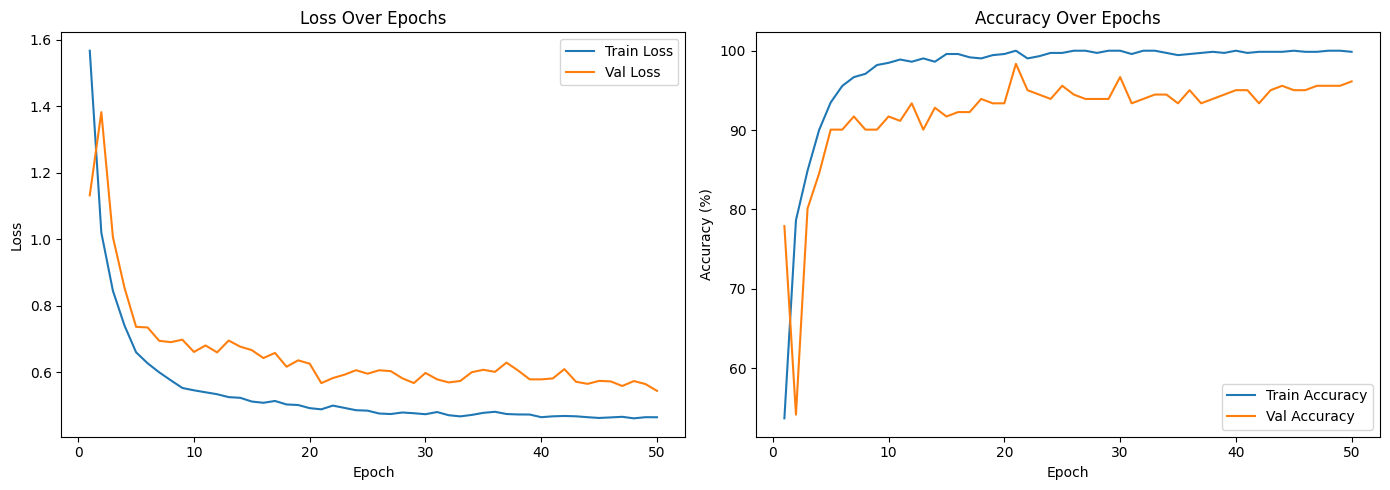

In [81]:
plot_training(history)

In [82]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Define all possible labels (0 to 6 for FER2013)
    all_possible_labels = list(range(len(class_names))) if class_names else sorted(list(set(all_labels + all_preds)))

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, labels=all_possible_labels, zero_division=0)) # Added labels and zero_division

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels) # Added labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


📊 Classification Report:
              precision    recall  f1-score   support

       Angry       0.86      0.67      0.75         9
     Disgust       0.92      1.00      0.96        12
        Fear       1.00      0.80      0.89         5
       Happy       0.93      1.00      0.97        14
         Sad       0.67      0.40      0.50         5
    Surprise       1.00      1.00      1.00        17
     Neutral       0.98      1.00      0.99       119

    accuracy                           0.96       181
   macro avg       0.91      0.84      0.86       181
weighted avg       0.96      0.96      0.96       181



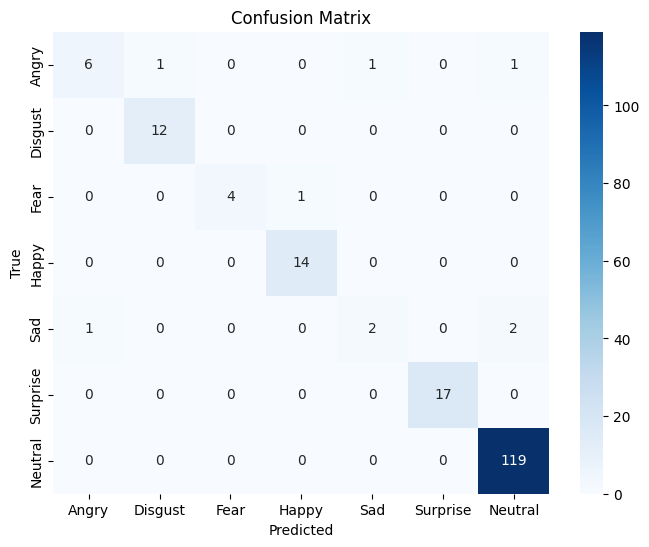

In [83]:
class_names = ['Angry', 'Disgust', 'Fear','Happy', 'Sad', 'Surprise', 'Neutral']
model.load_state_dict(torch.load("best_model.pth"))
evaluate_on_test(model, val_loader, device, class_names)
